In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 16px;
</style>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta  
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from nltk import word_tokenize, pos_tag
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# df = pd.read_csv('../data/2020 Presidency Ads.csv')
# df.shape

In [4]:
df = pd.read_csv('../data/2020 Presidential Ads WITH TONE.csv')
df.shape

(484392, 74)

In [5]:
senate = pd.read_csv('../data/facebook_ad_Senate_issues.csv')
senate.head()

id          state         candidate       party  \
0  1.008560e+14        Montana        Jon Tester  Democratic   
1  1.019970e+14  Massachusetts  Elizabeth Warren  Democratic   
2  1.026680e+14        Arizona    Kyrsten Sinema  Democratic   
3  1.031110e+14          Texas     Beto O'Rourke  Democratic   
4  1.035630e+14  Massachusetts  Elizabeth Warren  Democratic   

    competitiveness      status vote_results  vote_pct ad_start_time  \
0            Tossup   Incumbent          Won      0.50     5/15/2018   
1  Solid Democratic   Incumbent          Won      0.60     5/20/2018   
2            Tossup        Open          Won      0.50     5/22/2018   
3            Tossup  Challenger         Lost      0.48     9/27/2018   
4  Solid Democratic   Incumbent          Won      0.60     9/28/2018   

  ad_stop_time       page_id         page_name        funding_entity  \
0    5/17/2018  6.316744e+09        Jon Tester  Montanans for Tester   
1    5/21/2018  3.847105e+10  Elizabeth Warren      Elizabeth for MA   
2    5/31/2018  5.256365e+10    Kyrsten Sinema    Sinema for Arizona   
3    9/27/2018  2.230560e+14     Beto O'Rourke        Beto for Texas   
4    9/30/2018  3.847105e+10  Elizabeth Warren      Elizabeth for MA   

                                        ad_body_text        ad_link_caption  \
0  I�m leading a bipartisan coalition of business...   secure.jontester.com   
1  The bank lobbyists have a Dodd-Frank rollback ...    ELIZABETHWARREN.COM   
2  Do you think politicians should be able to mak...  act.kyrstensinema.com   
3  Come meet Congressman Beto O'Rourke at UT Arli...  Beto at UT Arlington!   
4  Brett Kavanaugh has shown us that it�s more im...    elizabethwarren.com   

                                 ad_link_description  \
0  Demand that Congress put the Yellowstone Gatew...   
1                                                NaN   
2                                 What do you think?   
3                      TBD, TBD, Arlington, TX 76019   
4                                     DEADLINE: 9/30   

                                   ad_link_title  spend_lower  spend_upper  \
0           Tell Congress to protect Yellowstone          200          299   
1  Tell Congress: Don�t Weaken Wall Street Rules            0           99   
2                        Survey (Women�s Health)            0           99   
3                          Beto at UT Arlington!            0           99   
4                   Donate Now to Join the Fight            0           99   

   impressions_lower  impressions_upper  male  female  age18_24  age25_34  \
0            10000.0            14999.0  0.40    0.60      0.06      0.16   
1             1000.0             1999.0  1.00    0.00      0.00      0.00   
2                0.0              999.0  0.35    0.64      0.07      0.10   
3             1000.0             1999.0  0.39    0.61      0.74      0.25   
4             5000.0             5999.0  0.24    0.75      0.00      0.00   

   age35_44  age45_54  age55_64  age65plus  \
0      0.18      0.17      0.21       0.22   
1      0.00      0.00      1.00       0.00   
2      0.12      0.17      0.27       0.25   
3      0.00      0.00      0.00       0.00   
4      0.00      0.19      0.43       0.37   

                                     ad_snapshot_url  issue_content  \
0  https://www.facebook.com/ads/archive/render_ad...              1   
1  https://www.facebook.com/ads/archive/render_ad...              1   
2  https://www.facebook.com/ads/archive/render_ad...              1   
3  https://www.facebook.com/ads/archive/render_ad...              0   
4  https://www.facebook.com/ads/archive/render_ad...              1   

   issue_economy  issue_tax  issue_business  issue_jobs  issue_income  \
0              0          0               1           0             0   
1              0          0               1           0             0   
2              0          0               0           0             0   
3              0      

### Use ads after April 8th (the day Bernie Sanders endorsed Joe Biden)

In [6]:
df = df[df.apply(lambda x: datetime.strptime(x.ad_start_time, '%m/%d/%Y') > datetime.strptime('04/08/2020', '%m/%d/%Y'), axis=1)]
df.shape


(478061, 74)

In [7]:
df['mean_impression'] = (df.impressions_lower + df.impressions_upper)/2
unique_ads = pd.DataFrame(df.groupby(['ad_body_text', 'party'], as_index=False)['mean_impression'].agg(['sum', 'size']))
unique_ads.rename(columns={'sum': 'mean_impression', 'size':'ad_count'}, inplace=True)
unique_ads.reset_index(inplace=True)
unique_ads['mean_impression'] = (unique_ads['mean_impression']).astype('int')
unique_ads = unique_ads[~unique_ads.ad_body_text.isna()]
unique_ads.head()

ad_body_text       party  \
0   450 ENDORSERS NEEDED \r\n\r\nWith ONE MONTH t...  Democratic   
1   Attention Patriots \r\n\r\nIn a little less t...  Republican   
2   Attention Patriots \r\n\r\nIn a little less t...  Republican   
3   Attention Patriots \r\n\r\nThe Left has been ...  Republican   
4   Attention Republicans \r\n\r\nIn a little les...  Republican   

   mean_impression  ad_count  
0            21491        17  
1           238992        15  
2            86485        29  
3            13486        27  
4           359418       163

In [8]:
rep_ads = unique_ads[unique_ads.party=='Republican']
dem_ads = unique_ads[unique_ads.party=='Democratic']

In [9]:
i=45
clean_text = re.sub(r'[^\w ,.]',' ',"From building back a better economy to lowering health care costs, a Democratic Senate is critical for achieving every goal we’re working for. That’s why we’re launching our Flip the Senate Fund.")
clean_text = re.sub(r'[\n\r\t]','. ',clean_text)

text = word_tokenize(clean_text.lower())
text = list(map((lambda x: x if x not in ['s', 't', 'm'] else ''), text))
text = list(filter(None, text))
pos_tags = pos_tag(text)
pos_tags

[('from', 'IN'),
 ('building', 'VBG'),
 ('back', 'RP'),
 ('a', 'DT'),
 ('better', 'JJR'),
 ('economy', 'NN'),
 ('to', 'TO'),
 ('lowering', 'VBG'),
 ('health', 'NN'),
 ('care', 'NN'),
 ('costs', 'NNS'),
 (',', ','),
 ('a', 'DT'),
 ('democratic', 'JJ'),
 ('senate', 'NN'),
 ('is', 'VBZ'),
 ('critical', 'JJ'),
 ('for', 'IN'),
 ('achieving', 'VBG'),
 ('every', 'DT'),
 ('goal', 'NN'),
 ('we', 'PRP'),
 ('re', 'VBP'),
 ('working', 'VBG'),
 ('for', 'IN'),
 ('.', '.'),
 ('that', 'DT'),
 ('why', 'WRB'),
 ('we', 'PRP'),
 ('re', 'VBP'),
 ('launching', 'VBG'),
 ('our', 'PRP$'),
 ('flip', 'NN'),
 ('the', 'DT'),
 ('senate', 'NN'),
 ('fund', 'NN'),
 ('.', '.')]

In [10]:
def create_keyword_phrases(df):
    noun_adj = ['JJ', 'NN']
    multiple_nouns = ['NN', 'NN']
    dt_noun = ['DT', 'NN']

    for index, row in df.iterrows():
        nn_list = ""
        an_list = ""
        dn_list = ""
        
        clean_text = re.sub(r'[^\w ,.]',' ', row.ad_body_text)
        clean_text = re.sub(r'[\n\r\t]','. ', clean_text)
        text = word_tokenize(clean_text.lower())
        text = list(map((lambda x: x if x not in ['s', 't', 'm'] else ''), text))
        text = list(filter(None, text))
        pos_tags = pos_tag(text)

        multiple_noun_flag = 0
        found= []
        cursor = 0

        for (w, tag) in pos_tags:    
            if  multiple_nouns[cursor] in tag:
                cursor += 1
                found += [w] 
                if cursor == len(multiple_nouns):
                    multiple_noun_flag = 1
                    cursor = 0
            else:
                if 'NN' in tag and multiple_noun_flag==1:
                    found += [w]

                else:
                    if multiple_noun_flag==1:
                        nn_list = nn_list + '+' + (' '.join(found))
                        cursor = 0
                        found = []
                        multiple_noun_flag = 0
                    else:    
                        cursor = 0
                        found = []
                        if  multiple_nouns[cursor] in tag:
                            cursor += 1
                            found += [w]
        df.loc[index, 'nn'] = nn_list

        adj_noun_flag = 0
        cursor = 0
        found = []

        for (w, tag) in pos_tags:    
            if  noun_adj[cursor] in tag:
                cursor += 1
                found += [w] 
                if cursor == len(noun_adj):
                    found = found[:-1]
                    adj_noun_flag = 1
                    cursor = 0

            if 'NN' in tag and adj_noun_flag==1:
                found += [w]

            else:
                if adj_noun_flag==1:
                    an_list = an_list + '+' + (' '.join(found))
                    cursor = 0
                    found = []
                    adj_noun_flag = 0
                else:    
                    cursor = 0
                    found = []
                    if  noun_adj[cursor] in tag:
                        cursor += 1
                        found += [w]
        df.loc[index, 'an'] = an_list
        
        
        det_noun_flag = 0
        cursor = 0
        found = []

        for (w, tag) in pos_tags:    
            if  dt_noun[cursor] in tag:
                cursor += 1
                found += [w] 
                if cursor == len(dt_noun):
                    found = found[:-1]
                    det_noun_flag = 1
                    cursor = 0

            if 'NN' in tag and det_noun_flag==1:
                found += [w]

            else:
                if det_noun_flag==1:
                    dn_list = dn_list + '+' + (' '.join(found))
                    cursor = 0
                    found = []
                    det_noun_flag = 0
                else:    
                    cursor = 0
                    found = []
                    if  dt_noun[cursor] in tag:
                        cursor += 1
                        found += [w]
        df.loc[index, 'dn'] = dn_list


                        
    return df

In [11]:
dem_ads.reset_index(drop=True, inplace=True)
dem_df = create_keyword_phrases(dem_ads)

dem_df['nn'] = dem_df['nn'].apply(lambda x: x.split('+')[1:])
dem_df['an'] = dem_df['an'].apply(lambda x: x.split('+')[1:])
dem_df['dn'] = dem_df['dn'].apply(lambda x: x.split('+')[1:])


dem_df.head()

ad_body_text       party  \
0   450 ENDORSERS NEEDED \r\n\r\nWith ONE MONTH t...  Democratic   
1   Bring manufacturing home to American workers\...  Democratic   
2   FREE Phone Background \r\n\r\nChip in to elec...  Democratic   
3   Fundraising Deadline \r\n\r\nHey folks, it's ...  Democratic   
4   It's Almost Election Day \r\n\r\nOur path to ...  Democratic   

   mean_impression  ad_count  \
0            21491        17   
1            25992        16   
2            57990        20   
3          4302488        25   
4            29973        54   

                                                  nn  \
0                                        [joe biden]   
1                   [manufacturing home, way things]   
2          [phone background chip, phone background]   
3                               [deadline hey folks]   
4  [election day, drive historic turnout, beat tr...   

                                                  an  \
0  [national convention, strong democrats, pm dea...   
1  [american workers, clean energy future, system...   
2  [free phone background chip, downloadable phon...   
3  [fec end, last month, crucial days, quarterly ...   
4  [clear drive historic turnout, uncontestable m...   

                                                  dn  
0                                                 []  
1                       [the burden, the way things]  
2                                                 []  
3              [the numbers, this quarter, the race]  
4  [the gop, the voter education fund, this elect...

In [12]:
flatten = lambda x: [item for sublist in x for item in sublist]

pd.DataFrame(pd.Series(flatten(dem_df.an * (dem_df.ad_count).astype(int))).value_counts()[0:10])


0
donald trump         15974
white house           5301
joe biden             2404
final days            1768
american people       1676
national convention   1558
single vote           1447
clear i               1432
united states         1383
few minutes           1286

In [13]:
for i in dem_df.ad_body_text:
    if "unborn" in i.lower():
        print(i)
        print('-'*55)

In [14]:
pd.DataFrame(pd.Series(flatten(dem_df.an * dem_df.ad_count)).value_counts()[:5])

0
donald trump     15974
white house       5301
joe biden         2404
final days        1768
american people   1676

In [15]:
rep_ads.reset_index(drop=True, inplace=True)
rep_ads = create_keyword_phrases(rep_ads)

rep_ads['nn'] = rep_ads['nn'].apply(lambda x: x.split('+')[1:])
rep_ads['an'] = rep_ads['an'].apply(lambda x: x.split('+')[1:])


rep_ads.head()

ad_body_text       party  \
0   Attention Patriots \r\n\r\nIn a little less t...  Republican   
1   Attention Patriots \r\n\r\nIn a little less t...  Republican   
2   Attention Patriots \r\n\r\nThe Left has been ...  Republican   
3   Attention Republicans \r\n\r\nIn a little les...  Republican   
4   Attention Republicans \r\n\r\nIn a little les...  Republican   

   mean_impression  ad_count  \
0           238992        15   
1            86485        29   
2            13486        27   
3           359418       163   
4           190985        29   

                                                  nn  \
0  [attention patriots, nation fall, government s...   
1  [attention patriots, nation fall, government s...   
2  [isis leaders, court justices, tax cuts, natio...   
3  [attention republicans, nation fall, governmen...   
4  [attention republicans, nation fall, governmen...   

                                                  an  \
0  [american people, big government socialist, ha...   
1  [american people, big government socialist, ha...   
2  [half years, radical isis leaders, supreme cou...   
3  [american people, big government socialist, ha...   
4  [american people, big government socialist, ha...   

                                                  dn  
0  +the hands+the left+every move+the odds+this n...  
1            +the hands+the left+every move+the odds  
2  +the left+every move+the odds+a look+the natio...  
3            +the hands+the left+every move+the odds  
4            +the hands+the left+every move+the odds

In [16]:
for i in rep_ads.ad_body_text:
    if 'immigration' in i.lower():
        print(i)

DEMOCRATS HAVE CHOSEN ILLEGAL IMMIGRANTS OVER THE AMERICAN PEOPLE FOR TOO LONG!

Joe Biden supports giving taxpayer-funded health care to illegal immigrants for FREE. He voted for and supported efforts to GRANT AMNESTY to MILLIONS of illegal immigrants. 

President Trump wants to protect America's borders and END illegal immigration. Contribute TODAY to support President Trump's efforts to protect the American people.
DEMOCRATS HAVE CHOSEN ILLEGAL IMMIGRANTS OVER THE AMERICAN PEOPLE FOR TOO LONG!

Joe Biden supports giving taxpayer-funded health care to illegal immigrants for FREE. He voted for and supported efforts to GRANT AMNESTY to MILLIONS of illegal immigrants. 

President Trump wants to protect America's borders and END illegal immigration. Stand with President Trump TODAY!
IMMIGRATION UPDATE

In light of the attack from the Invisible Enemy, as well as the need to protect the jobs of our GREAT American Citizens, the President announced that he will be signing an Executive Order 

In [17]:
# for i in 
dict(pd.Series(flatten(dem_ads.nn * dem_ads.ad_count)).value_counts()[:30])
#     print(i)

{'joe biden': 12212,
 'election day': 8194,
 'donald trump': 4363,
 'battleground states': 2338,
 'health care': 1500,
 'president obama': 1337,
 'kamala harris': 1258,
 'name today': 1232,
 'vice president': 1195,
 'trump campaign': 1189,
 'fact joe biden': 1033,
 'donation today': 986,
 'midnight tonight': 937,
 'blue america': 927,
 'click below': 905,
 'term president': 832,
 'vote please': 803,
 'election poll': 797,
 'voter registration': 763,
 'grassroots donors': 713,
 'couple minutes': 683,
 'joe voters': 675,
 'vote share numbers': 675,
 'p.m. tonight': 668,
 'election deadline': 630,
 'care act': 621,
 'voter outreach': 603,
 'joe biden plan': 593,
 'service members': 564,
 'truth joe biden': 548}

In [18]:
word_cloud = {
 'joe biden': 59431,
 'news media': 32186,
 'sleepy joe': 12303,
 'washington swamp': 11035,
 'government socialist followers': 9731,
 'vice president pence': 9550,
 'democrat corruption accountability survey': 5275,
 'president birthday': 5185,
 'donor list': 4819,
 'court confirmation': 3441,
 'trade deals': 3031,
 'vip guest': 3020,
 'swamp fund': 2966,
 'health care': 2951,
 'barack obama': 2873,
 'judge barrett': 2834,
 'gop convention': 2706,
 'trump ad blitz fund': 2476,
 'violent crime': 2461,
 'medicare benefits': 2355,
 'amendment rights': 2107,
 'gun control measures': 2054,
 'kind messages': 2047,
 'birthday card': 2047,
 'president acceptance speech': 1989,
 'healthcare costs': 1986,
 'insulin cuts': 1986,
 'election campaign trump maga rally': 1968,
 'drug prices': 1852,
 'trump pence': 1848,
 'match contribute': 1841,
 'trump priorities survey': 1837,
 'corner president trump': 1837,
 'payment protection program': 1815,
 'hollywood elites': 1807,
 'wall petition': 1778,
 'justice ruth bader ginsburg': 1775,
 'coney barrett president trump': 1732,
 'government socialist policies': 1680,
 'defense fund': 1598,
 'law enforcement': 1573,
 'government socialist': 1567,
 'grassroots donors': 1526,
  
 'three and half years': 45343,
 'radical left': 36081,
 'fake news media': 32186,
 'american dream': 26698,
 'forgotten men': 26524,
 'equal opportunity': 26524,
 'single citizen': 26524,
 'real americans': 24394,
 'free tickets': 20514,
 'democratic party': 19561,
 'silent majority': 18900,
 'birthday card': 15572,
 'illegal immigrants': 15509,
 'first lady': 14933,
 'american people': 12162,
 'new taxes': 10908,
 'big government socialist followers': 9731,
 'radical democrats': 8366,
 'helpless puppet': 8069,
 'social security': 6459,
 'high sellout risk': 5929,
 'official democrat corruption accountability survey': 5275,
 'american patriots': 4937,
 'presidential donor list': 4819,
 'biden running mate': 4775,
 'donor money': 4775,
 'american jobs': 4443,
 'great nation': 4325,
 'amy coney barrett': 4081,
 'warm wishes': 4062,
 'presidential debate': 4058,
 'true constitutionalist': 4055,
 'american comeback': 4047,
 'official petition': 4042,
 'united message': 3935,
 'strongest supporters': 3932,
 'last month': 3874,
 'big government socialist': 3872,
 'supreme court nominee': 3775,
 'extended end': 3745,
 'first lady birthday': 3722,
 'kamala harris': 3719,
 'public statement': 3658,
 'official trump approval poll': 3466,
 'supreme court confirmation': 3441,
 'enough resources': 3414,
 'big pharma': 3385,
 'first time': 3380,
 'strong leadership': 3330,
 'first opportunity': 3217,
 'fake news': 3214,
 'dangerous mobs': 3174,
 'absolute mayhem': 3174,
 'only way': 3133,
 'incredible vice president debate kamala harris': 3091,
 'american greatness': 3026,
 'top supporters': 3015,
 'fundraising goal': 2861,
 'strong message': 2833,
 'contribute today': 2824,
 'great work': 2780,
 'vip access': 2741,
 'socialist scheme': 2676,
 'greatest line': 2676,
 'american democracy': 2676,
 'radical actions': 2512,
 'sleepy joe biden': 2496,
 'mental fortitude': 2476,
 'official trump ad blitz fund': 2476,
 'gdp numbers': 2455,
 'exclusive group': 2392,
 'critical moment': 2382,
 'amazing life': 2382,
 'amazing woman': 2382,
 'new ad': 2375,
 'unprecedented challenges': 2356,
 'american interests': 2355,
 'personal note': 2313,
 'special vip guest': 2247,
 'many americans': 2245,
 'terrorist organization': 2157,
 'left groups': 2130,
 'absolute madness': 2130,
 'american people president trump': 2129,
 'second amendment rights': 2107,
 'highest gdp': 2091,
 'unconstitutional gun control measures': 2054,
 'favored nation status': 2046,
 'crazy bernie': 2024,
 'crush sleepy joe': 1977,
 're election campaign trump maga rally': 1968}

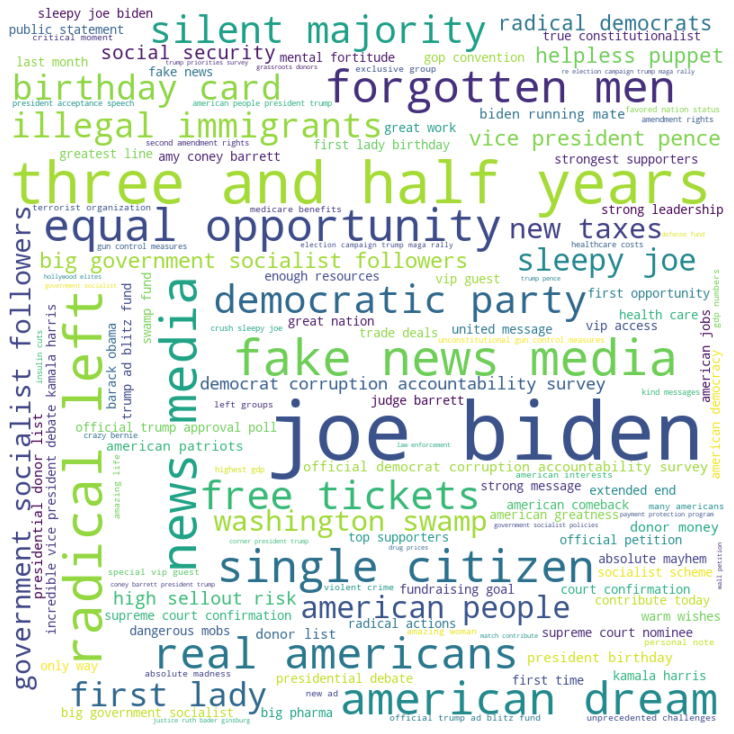

In [19]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', colormap='viridis').generate_from_frequencies(word_cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('./word_cloud_dem.png')
plt.show() 

In [20]:
extra_issues = ['big pharma', 'payment protection', 'global pandemic', 'coronavirus', 'covid']

In [21]:
for i in rep_ads.ad_body_text:
    if 'big pharma' in i.lower():
        print(i)
        print('-'*88)

Big Pharma liked it better with Joe Biden when healthcare costs were SKYROCKETING. 

Here's what President Trump's plan REALLY does:
REDUCES Medicare and prescription drug prices
REDUCES the cost of insulin
CUTS the cost of life-saving medicine

That's why Big Pharma is attacking President Trump.
----------------------------------------------------------------------------------------
President Trump's plan: 
REDUCES Medicare and prescription drug prices
REDUCES the cost of insulin
CUTS the cost of life-saving medicine

That's why Big Pharma is attacking President Trump. They liked it better with Joe Biden when healthcare costs SKYROCKETED.
----------------------------------------------------------------------------------------


In [22]:
pd.DataFrame(pd.Series(flatten(rep_ads.nn * rep_ads.ad_count)).value_counts()[0:10])

0
president trump                 244494
joe biden                        59431
news media                       32186
pm tonight                       30768
trump administration             26789
sleepy joe                       12303
washington swamp                 11035
government socialist followers    9731
vice president pence              9550
month goal                        9162

### Using senate ads to recognize keywords for issues

In [23]:
issue_cols = [col for col in senate.columns if 'issue' in col]
social_issue_cols = ["issue_abortion", "issue_race", "issue_gender", "issue_violence",
              "issue_assault", "issue_guns", "issue_lgbt"]
economic_issue_cols = ["issue_economy", "issue_tax", "issue_business", "issue_jobs",
                       "issue_income", "issue_housing", "issue_spending", "issue_trade",
                       "issue_infrastructure", "issue_farming", "issue_energy", "issue_drilling",
                       "issue_environment", "issue_disaster", "issue_lands", "issue_tourism"]
social_welfare_issue_cols = ["issue_healthcare", "issue_opioid", "issue_education",
                             "issue_leave", "issue_socialsecurity", "issue_welfare",
                             "issue_veterans"]
law_order_issue_cols = ["issue_crime", "issue_police", "issue_drugs", "issue_marijuana",
                        "issue_trafficking", "issue_courts", "issue_electoral", "issue_corruption"]
foreign_policy_issue_cols = ["issue_military", "issue_defense", "issue_immigration",
                             "issue_terrorism", "issue_nuclear", "issue_iran", "issue_china",
                             "issue_nkorea", "issue_russia", "issue_mexico", "issue_meast"]


In [24]:
issues = [social_issue_cols, economic_issue_cols, social_welfare_issue_cols, law_order_issue_cols,
         foreign_policy_issue_cols]

issue_dfs = []
for issue in issues:
    issue_ads = senate[senate[issue].sum(axis=1)>1]
    issue_ads.reset_index(drop=True, inplace=True)
    issue_ads = create_keyword_phrases(issue_ads)
    issue_ads['nn'] = issue_ads['nn'].apply(lambda x: x.split('+')[1:])
    issue_ads['an'] = issue_ads['an'].apply(lambda x: x.split('+')[1:])
    issue_ads['dn'] = issue_ads['dn'].apply(lambda x: x.split('+')[1:])
    issue_dfs.append(issue_ads)

In [180]:
issue_key_words = {
    "foreign_policy_issue": [
        "immigration",
        "immigrant",
        "national security",
        "taxpayer fund",
        "military",
        "border",
        "terrorism",
        "nuclear",
        "chinese",
        "china",
        "russia",
        "korea",
        "iran",
        "iraq",
        "security",
        "warfare",
        "defense"
    ],
    
    "law_order_issue": [
        "law enforcement",
        "trafficking",
        "brave men",
        "trafficking",
        "sexual assault",
        "opioid",
        "fbi investigation",
        "marijuana",
        "corruption",
        "crime"
    ],
    
    "economic_issue": [
        "small business",
        "renewable energy",
        "tax credits",
        "environment",
        "renewable energy",
        "economy",
        "agricultur",
        "trade wars",
        "jobs",
        "tariffs",
        "crude oil",
        "clean energy",
        "tax cuts",
        "energy jobs",
        "trade deals",
        "farming",
        "energy",
        "payment protection"
        
    ],
    "social_issue": ["brett kavanaugh",
                  "lgbtq",
                  "gun violence",
                  "tuition",
                   "woman's right",
                   "woman right",
                   "abortion",
                   "racial",
                   "assault weapons",
                   "violence against women act",
                   "black man",
                   "black people",
                   "black americans",
                   "black lives matter",
                   "civil rights",
                   "equal marriage",
                   "domestic violence"
                  ],
    "social_welfare_issue": [
        "healthcare",
        "health care",
        "obama care",
        "obamacare",
        "medicare",
        "social security",
        "drug costs",
        "veteran",
        "drug enforcement act",
        "opioid",
        "mental health"],
    
    "covid": [
        "covid",
        "coronavirus",
        "pandemic"
    ]
    
}

In [26]:
for index, row in unique_ads.iterrows():
    for kw in issue_key_words.keys():
        kws = issue_key_words[kw]
        for i in kws:
            if i in row.ad_body_text.lower():
                unique_ads.loc[index, kw] = 1

unique_ads = unique_ads.fillna(0)

In [27]:
unique_ads.head()

ad_body_text       party  \
0   450 ENDORSERS NEEDED \r\n\r\nWith ONE MONTH t...  Democratic   
1   Attention Patriots \r\n\r\nIn a little less t...  Republican   
2   Attention Patriots \r\n\r\nIn a little less t...  Republican   
3   Attention Patriots \r\n\r\nThe Left has been ...  Republican   
4   Attention Republicans \r\n\r\nIn a little les...  Republican   

   mean_impression  ad_count  foreign_policy_issue  economic_issue  covid  \
0            21491        17                   0.0             0.0    0.0   
1           238992        15                   0.0             0.0    0.0   
2            86485        29                   0.0             0.0    0.0   
3            13486        27                   1.0             1.0    0.0   
4           359418       163                   0.0             0.0    0.0   

   law_order_issue  social_welfare_issue  social_issue  
0              0.0                   0.0           0.0  
1              0.0                   0.0           0.0  
2              0.0                   0.0           0.0  
3              0.0                   0.0           0.0  
4              0.0                   0.0           0.0

In [28]:
unique_ads.covid.sum()

61.0

In [29]:
for index, row in unique_ads.iterrows():
    for kw in action_terms.keys():
        kws = action_terms[kw]
        for i in kws:
            if i in row.ad_body_text.lower():
                unique_ads.loc[index, kw] = 1

unique_ads = unique_ads.fillna(0)
unique_ads.head()

NameError: name 'action_terms' is not defined

In [31]:
df_1 = pd.merge(df, unique_ads, on='ad_body_text', how='left')
df_1.head()

id     candidate     party_x ad_start_time ad_stop_time  \
0   604406720200059  Donald Trump  Republican     6/15/2020    6/22/2020   
1   283948239393377  Donald Trump  Republican     6/15/2020    6/15/2020   
2   286624085822005  Donald Trump  Republican     6/15/2020    6/22/2020   
3   284384622920839  Donald Trump  Republican     6/15/2020    6/15/2020   
4  2617435251846400  Donald Trump  Republican     6/15/2020    6/18/2020   

         page_name                            funding_entity  \
0  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
1  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
2  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
3  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
4  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   

                                        ad_body_text   ad_link_caption  \
0   Attention Patriots \r\n\r\nIn a little less t...  donaldjtrump.com   
1   Attention Patriots \r\n\r\nIn a little less t...  donaldjtrump.com   
2   Attention Patriots \r\n\r\nIn a little less t...  donaldjtrump.com   
3   Attention Patriots \r\n\r\nIn a little less t...  donaldjtrump.com   
4   Attention Patriots \r\n\r\nIn a little less t...  donaldjtrump.com   

  ad_link_description    ad_link_title  \
0   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
1   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
2   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
3   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
4   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   

                                     ad_snapshot_url  spend_lower  \
0  https://www.facebook.com/ads/archive/render_ad...          300   
1  https://www.facebook.com/ads/archive/render_ad...            0   
2  https://www.facebook.com/ads/archive/render_ad...          200   
3  https://www.facebook.com/ads/archive/render_ad...            0   
4  https://www.facebook.com/ads/archive/render_ad...          400   

   spend_upper  impressions_lower  impressions_upper  male  female  age18_24  \
0          399              10000            14999.0  0.74    0.25      0.01   
1           99               2000             2999.0  0.76    0.23      0.01   
2          299              20000            24999.0  0.73    0.26      0.02   
3           99               2000             2999.0  0.64    0.35      0.03   
4          499              20000            24999.0  0.73    0.26      0.02   

   age25_34  age35_44  age45_54  age55_64  age65plus   Alabama    Alaska  \
0      0.02      0.03      0.11      0.27       0.55  0.031371  0.003445   
1      0.04      0.09      0.18      0.31       0.35  0.021577  0.002354   
2      0.07      0.14      0.21      0.27       0.29  0.022069  0.003296   
3      0.07      0.13      0.21      0.28       0.26  0.025030  0.002384   
4      0.04      0.07      0.14      0.25       0.46  0.031841  0.002309   

    Arizona  Arkansas  California  Colorado  Connecticut  Delaware   Florida  \
0  0.026167  0.015099    0.079528  0.012461     0.006304  0.002859  0.065382   
1  0.028639  0.009808    0.107493  0.017262     0.008239  0.003531  0.080031   
2  0.023321  0.013767    0.134460  0.014435     0.006633  0.002587  0.062370   
3  0.023838  0.014303    0.066746  0.009932     0.008741  0.001986  0.067143   
4  0.021596  0.014814    0.100813  0.011014     0.006782  0.002405  0.061565   

    Georgia    Hawaii     Idaho  Illinois   Indiana      Iowa    Kansas  \
0  0.028953  0.002272  0.009016  0.037968  0.033864  0.009382  0.010848   
1  0.040408  0.001962  0.007062  0.034131  0.020792  0.010592  0.005885   
2  0.026783  0.003463  0.008803  0.036504  0.024406  0.009637  0.009595   
3  0.043306  0.000795  0.011124  0.037346  0.022646  0.010330  0.010727   
4  0.032466  0.002261  0.007167  0.042134  0.028811  0.008609  0.011014   

   Kentucky  Louisiana     Maine  Maryland  Massachusetts  Michigan  \
0  0.019937   0.018178  0.003079  0.013707       0.011361  0.024481   
1  0.012162   0.016477  0.003923  0.019616       0

In [32]:
state_cols = ['Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New_Hampshire', 'New_Jersey', 'New_Mexico',
       'New_York', 'North_Carolina', 'North_Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode_Island', 'South_Carolina',
       'South_Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West_Virginia', 'Wyoming']
df_1[state_cols].sum(axis=1).describe()

count    478061.000000
mean          0.939659
std           0.212460
min           0.000000
25%           0.980579
50%           1.000000
75%           1.000000
max           1.000015
dtype: float64

In [33]:
df_1.impressions_upper.fillna(1000000, inplace=True)
df_1['mean_impressions'] = (df_1['impressions_lower'] + df_1['impressions_upper'])/2
for i in state_cols:
    df_1[i+'_impressions'] = df_1['mean_impressions']*df_1[i]
    df_1[i+'_impressions'] = df_1[i+'_impressions'].astype('int')

In [34]:
state_impression_cols = ['Alabama_impressions',
       'Alaska_impressions', 'Arizona_impressions', 'Arkansas_impressions',
       'California_impressions', 'Colorado_impressions',
       'Connecticut_impressions', 'Delaware_impressions',
       'Florida_impressions', 'Georgia_impressions', 'Hawaii_impressions',
       'Idaho_impressions', 'Illinois_impressions', 'Indiana_impressions',
       'Iowa_impressions', 'Kansas_impressions', 'Kentucky_impressions',
       'Louisiana_impressions', 'Maine_impressions', 'Maryland_impressions',
       'Massachusetts_impressions', 'Michigan_impressions',
       'Minnesota_impressions', 'Mississippi_impressions',
       'Missouri_impressions', 'Montana_impressions', 'Nebraska_impressions',
       'Nevada_impressions', 'New_Hampshire_impressions',
       'New_Jersey_impressions', 'New_Mexico_impressions',
       'New_York_impressions', 'North_Carolina_impressions',
       'North_Dakota_impressions', 'Ohio_impressions', 'Oklahoma_impressions',
       'Oregon_impressions', 'Pennsylvania_impressions',
       'Rhode_Island_impressions', 'South_Carolina_impressions',
       'South_Dakota_impressions', 'Tennessee_impressions',
       'Texas_impressions', 'Utah_impressions', 'Vermont_impressions',
       'Virginia_impressions', 'Washington_impressions',
       'West_Virginia_impressions', 'Wyoming_impressions']

df_1[state_impression_cols].sum().sort_values(ascending=False)

Florida_impressions           914705711
Pennsylvania_impressions      638736271
Michigan_impressions          474431632
North_Carolina_impressions    463865982
California_impressions        405334627
Texas_impressions             387062808
Georgia_impressions           354268634
Arizona_impressions           314829848
Ohio_impressions              284742653
New_York_impressions          233739734
Minnesota_impressions         162169796
Illinois_impressions          147574357
Virginia_impressions          133758169
Nevada_impressions            111383276
Iowa_impressions              109588731
Washington_impressions        106152006
Tennessee_impressions          99201307
Colorado_impressions           97325065
New_Jersey_impressions         95870597
Indiana_impressions            90726940
Missouri_impressions           87413155
Massachusetts_impressions      86910597
Alabama_impressions            73395812
Maryland_impressions           66448536
Kentucky_impressions           65353629


In [35]:
issue_cols = ['economic_issue', 'law_order_issue', 'social_welfare_issue', 'social_issue', 'foreign_policy_issue']

df_1[df_1.economic_issue>0][state_impression_cols].sum().sort_values(ascending=False).head()


Florida_impressions           20863394
Pennsylvania_impressions      12617767
North_Carolina_impressions    11135844
Georgia_impressions            9844860
Michigan_impressions           9195216
dtype: int64

In [36]:
df_1[df_1.law_order_issue>0][state_impression_cols].sum().sort_values(ascending=False).head()

Texas_impressions           32034292
Florida_impressions         28495550
Ohio_impressions            21189254
Pennsylvania_impressions    19321212
Michigan_impressions        15953877
dtype: int64

In [37]:
df_1[df_1.social_welfare_issue>0][state_impression_cols].sum().sort_values(ascending=False).head()

Florida_impressions           19579295
North_Carolina_impressions    12771274
Michigan_impressions          12735614
Pennsylvania_impressions      12723618
Georgia_impressions            9154458
dtype: int64

In [38]:
df_1[df_1.social_issue>0][state_impression_cols].sum().sort_values(ascending=False).head()

California_impressions      3345527
Pennsylvania_impressions    3300603
Florida_impressions         3016993
Texas_impressions           2973299
Ohio_impressions            2258210
dtype: int64

In [39]:
df_1[df_1.foreign_policy_issue>0][state_impression_cols].sum().sort_values(ascending=False).head()

Florida_impressions         16738286
Ohio_impressions            10817098
Michigan_impressions        10788977
Pennsylvania_impressions     9584651
Texas_impressions            8764473
dtype: int64

In [41]:
issue = 'social_issue'
social_df = df_1[df_1[issue]>0].groupby(['party_x'])[state_impression_cols].agg('sum')
social_df.loc['sum', :] = social_df.sum()
social_df = social_df.transpose()
social_df.sort_values(by='Republican',ascending=False, inplace=True)
social_df.head(5)

party_x                   Democratic  Republican        sum
Florida_impressions         755968.0   2261025.0  3016993.0
Texas_impressions           811734.0   2161565.0  2973299.0
Ohio_impressions            431990.0   1826220.0  2258210.0
Pennsylvania_impressions   1788393.0   1512210.0  3300603.0
California_impressions     2181950.0   1163577.0  3345527.0

In [42]:
list(social_df.Republican[:5])

[2261025.0, 2161565.0, 1826220.0, 1512210.0, 1163577.0]

In [43]:
df_1.columns

Index(['id', 'candidate', 'party_x', 'ad_start_time', 'ad_stop_time',
       'page_name', 'funding_entity', 'ad_body_text', 'ad_link_caption',
       'ad_link_description',
       ...
       'South_Carolina_impressions', 'South_Dakota_impressions',
       'Tennessee_impressions', 'Texas_impressions', 'Utah_impressions',
       'Vermont_impressions', 'Virginia_impressions', 'Washington_impressions',
       'West_Virginia_impressions', 'Wyoming_impressions'],
      dtype='object', length=134)

In [44]:
def plot_issue_by_state(issue, plot_title):
    social_df = df_1[df_1[issue]>0].groupby(['party_x'])[state_impression_cols].agg('sum')
    social_df.loc['sum', :] = social_df.sum()
    social_df = social_df.transpose()
    social_df.sort_values(by='sum',ascending=False, inplace=True)
    ind = np.arange(5)
    width=0.3
    plt.bar(ind, list(social_df.Republican[:5]), width, label='Republican', color='r')
    plt.bar(ind + width, list(social_df.Democratic[:5]) , width, label='Democratic', color='b')
    plt.xticks(ind + width / 2, list(map(lambda x: x.split('_im')[0],social_df.index[:5])))
    plt.xlabel('State')
    plt.ylabel('Ad count')
#     plt.title('Party wise distribution of ads mentioning '+plot_title)
    plt.legend(loc='best')
    plt.show()

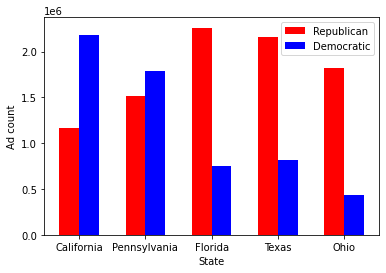

In [45]:
plot_issue_by_state('social_issue', 'SOCIAL ISSUES')

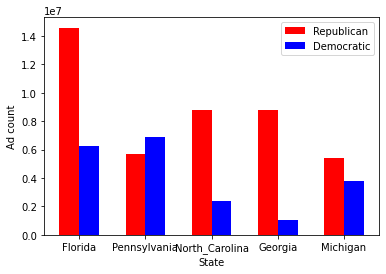

In [46]:
plot_issue_by_state('economic_issue', 'ECONOMIC ISSUES')

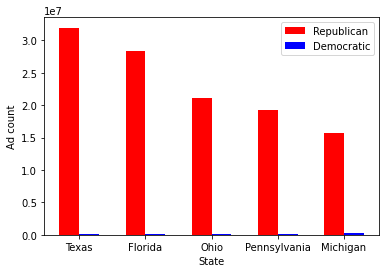

In [47]:
plot_issue_by_state('law_order_issue', 'LAW and ORDER ISSUES')

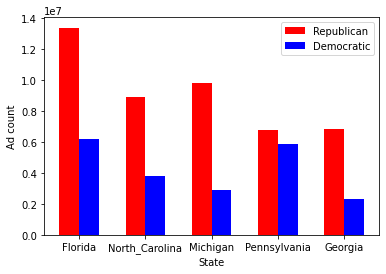

In [48]:
plot_issue_by_state('social_welfare_issue', 'SOCIAL WELFARE ISSUES')

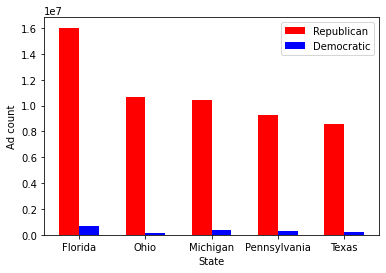

In [49]:
plot_issue_by_state('foreign_policy_issue', 'FOREIGN POLICY ISSUES')

## Action and issue detections

In [51]:
df = pd.read_csv('../data/2020 Presidential Ads WITH TONE.csv')
df.shape

(484392, 74)

### Filter out data before democratic primary elections

In [52]:
def check_date(date):
    ad_date = datetime.strptime(date, '%m/%d/%Y')
    primaries_date = datetime.strptime("4/8/2020", '%m/%d/%Y')
    if ad_date < primaries_date:
        return False
    return True

df["is_valid"] = df.apply(lambda row : \
                                      check_date(row.ad_start_time), axis=1)

df = df[df.is_valid == True]

In [53]:
pd.DataFrame(df.isna().sum())[pd.DataFrame(df.isna().sum())[0]>0]

0
ad_body_text         22365
ad_link_caption        448
ad_link_description  32995
ad_link_title          832
impressions_upper     1018

In [54]:
## dropping the observations with empty ad body from the primary dataframe
df.dropna(subset=['ad_body_text'], inplace=True)

### Filling missing impressions data

In [55]:
df['impressions_upper'] = df['impressions_upper'].fillna(\
                                              max(df['impressions_lower']))

df['ad_body_text'] = df.apply(lambda row : \
                    re.sub(r'\r\n\r\n|\r\n|>+', ' ', row.ad_body_text),axis = 1)

In [56]:
df.head()

id     candidate       party ad_start_time ad_stop_time  \
0   604406720200059  Donald Trump  Republican     6/15/2020    6/22/2020   
1   283948239393377  Donald Trump  Republican     6/15/2020    6/15/2020   
2   286624085822005  Donald Trump  Republican     6/15/2020    6/22/2020   
3   284384622920839  Donald Trump  Republican     6/15/2020    6/15/2020   
4  2617435251846400  Donald Trump  Republican     6/15/2020    6/18/2020   

         page_name                            funding_entity  \
0  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
1  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
2  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
3  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
4  Donald J. Trump  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   

                                        ad_body_text   ad_link_caption  \
0   Attention Patriots  In a little less than 5 M...  donaldjtrump.com   
1   Attention Patriots  In a little less than 5 M...  donaldjtrump.com   
2   Attention Patriots  In a little less than 5 M...  donaldjtrump.com   
3   Attention Patriots  In a little less than 5 M...  donaldjtrump.com   
4   Attention Patriots  In a little less than 5 M...  donaldjtrump.com   

  ad_link_description    ad_link_title  \
0   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
1   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
2   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
3   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   
4   PLEDGE TO VOTE>>>  FIVE MONTHS OUT   

                                     ad_snapshot_url  spend_lower  \
0  https://www.facebook.com/ads/archive/render_ad...          300   
1  https://www.facebook.com/ads/archive/render_ad...            0   
2  https://www.facebook.com/ads/archive/render_ad...          200   
3  https://www.facebook.com/ads/archive/render_ad...            0   
4  https://www.facebook.com/ads/archive/render_ad...          400   

   spend_upper  impressions_lower  impressions_upper  male  female  age18_24  \
0          399              10000            14999.0  0.74    0.25      0.01   
1           99               2000             2999.0  0.76    0.23      0.01   
2          299              20000            24999.0  0.73    0.26      0.02   
3           99               2000             2999.0  0.64    0.35      0.03   
4          499              20000            24999.0  0.73    0.26      0.02   

   age25_34  age35_44  age45_54  age55_64  age65plus   Alabama    Alaska  \
0      0.02      0.03      0.11      0.27       0.55  0.031371  0.003445   
1      0.04      0.09      0.18      0.31       0.35  0.021577  0.002354   
2      0.07      0.14      0.21      0.27       0.29  0.022069  0.003296   
3      0.07      0.13      0.21      0.28       0.26  0.025030  0.002384   
4      0.04      0.07      0.14      0.25       0.46  0.031841  0.002309   

    Arizona  Arkansas  California  Colorado  Connecticut  Delaware   Florida  \
0  0.026167  0.015099    0.079528  0.012461     0.006304  0.002859  0.065382   
1  0.028639  0.009808    0.107493  0.017262     0.008239  0.003531  0.080031   
2  0.023321  0.013767    0.134460  0.014435     0.006633  0.002587  0.062370   
3  0.023838  0.014303    0.066746  0.009932     0.008741  0.001986  0.067143   
4  0.021596  0.014814    0.100813  0.011014     0.006782  0.002405  0.061565   

    Georgia    Hawaii     Idaho  Illinois   Indiana      Iowa    Kansas  \
0  0.028953  0.002272  0.009016  0.037968  0.033864  0.009382  0.010848   
1  0.040408  0.001962  0.007062  0.034131  0.020792  0.010592  0.005885   
2  0.026783  0.003463  0.008803  0.036504  0.024406  0.009637  0.009595   
3  0.043306  0.000795  0.011124  0.037346  0.022646  0.010330  0.010727   
4  0.032466  0.002261  0.007167  0.042134  0.028811  0.008609  0.011014   

   Kentucky  Louisiana     Maine  Maryland  Massachusetts  Michigan  \
0  0.019937   0.018178  0.003079  0.013707       0.011361  0.024481   
1  0.012162   0.016477  0.003923  0.019616       0

In [57]:
unique_ads = df["ad_body_text"].drop_duplicates().reset_index()

In [58]:
def text_preprocessor(text):
    text = str(text).lower()
    text = re.sub(r'\r+|\n+|>+', '', text)
    return text

unique_ads['processed'] = unique_ads.apply(lambda row : \
                                 text_preprocessor(row.ad_body_text), axis = 1)

In [211]:
from collections import defaultdict

key_phrases_actions = pd.read_excel("../data/keyphrases_actions.xlsx") 
key_phrase_dict = defaultdict(list)
last_val = ""
for i in range(len(key_phrases_actions)): 
    if not pd.isna(key_phrases_actions.loc[i,'Action']):
        last_val = key_phrases_actions.loc[i,'Action']
    key_phrase_dict[last_val].append(key_phrases_actions.iloc[i,1].lower())


In [212]:
for index, row in unique_ads.iterrows():
    for kw in key_phrase_dict.keys():
        kws = key_phrase_dict[kw]
        for i in kws:
            if i in row.ad_body_text.lower():
                unique_ads.loc[index, kw] = 1

unique_ads = unique_ads.fillna(0)

In [213]:
for index, row in unique_ads.iterrows():
    for kw in issue_key_words.keys():
        kws = issue_key_words[kw]
        for i in kws:
            if i in row.ad_body_text.lower():
                unique_ads.loc[index, kw] = 1

unique_ads = unique_ads.fillna(0)
unique_ads.head()

index                                       ad_body_text  \
0      0   Attention Patriots  In a little less than 5 M...   
1     15   Attention Patriots  In a little less than 6 M...   
2     44   Attention Patriots  The Left has been watchin...   
3     71   Attention Republicans  In a little less than ...   
4    234   Attention Republicans  In a little less than ...   

                                           processed  Take a poll or survey  \
0   attention patriots  in a little less than 5 m...                    0.0   
1   attention patriots  in a little less than 6 m...                    0.0   
2   attention patriots  the left has been watchin...                    1.0   
3   attention republicans  in a little less than ...                    0.0   
4   attention republicans  in a little less than ...                    0.0   

   Donate  Vote  Sign a petition or card  Register to vote  \
0     0.0   0.0                      0.0               0.0   
1     0.0   0.0                      0.0               0.0   
2     0.0   0.0                      0.0               0.0   
3     0.0   0.0                      0.0               0.0   
4     0.0   0.0                      0.0               0.0   

   Purchase merchandise  Get information  Enter a competition  \
0                   0.0              0.0                  0.0   
1                   0.0              0.0                  0.0   
2                   0.0              0.0                  0.0   
3                   0.0              0.0                  0.0   
4                   0.0              0.0                  0.0   

   Find your polling place  Attend an event  \
0                      0.0              0.0   
1                      0.0              0.0   
2                      0.0              0.0   
3                      0.0              0.0   
4                      0.0              0.0   

   Sign up or volunteer for campaign  foreign_policy_issue  economic_issue  \
0                                0.0                   0.0             0.0   
1                                0.0                   0.0             0.0   
2                                0.0                   1.0             1.0   
3                                0.0                   0.0             0.0   
4                                0.0                   0.0             0.0   

   law_order_issue  social_welfare_issue  covid  social_issue  
0              0.0                   0.0    0.0           0.0  
1              0.0                   0.0    0.0           0.0  
2              0.0                   0.0    0.0           0.0  
3              0.0                   0.0    0.0           0.0  
4              0.0                   0.0    0.0           0.0

In [222]:
unique_ads[unique_ads[['Take a poll or survey', 'Donate',
       'Vote', 'Sign a petition or card', 'Register to vote',
       'Purchase merchandise', 'Get information', 'Enter a competition',
       'Find your polling place', 'Attend an event',
       'Sign up or volunteer for campaign']].sum(axis=1)==0].shape

(1138, 20)

In [223]:
unique_ads[unique_ads[['Take a poll or survey', 'Donate',
       'Vote', 'Sign a petition or card', 'Register to vote',
       'Purchase merchandise', 'Get information', 'Enter a competition',
       'Find your polling place', 'Attend an event',
       'Sign up or volunteer for campaign', 'foreign_policy_issue',
       'economic_issue', 'law_order_issue', 'social_welfare_issue', 'covid',
       'social_issue']].sum(axis=1)==0].shape

(887, 20)

In [221]:
unique_ads.to_csv('../data/ad_issue_actions.csv')